In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
  sys.path.append("../") 

from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [2]:
env = gym.envs.make("MountainCar-v0")

In [3]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to convert a state to a featurizes represenation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=None,
             transformer_list=[('rbf1',
                                RBFSampler(gamma=5.0, n_components=100,
                                           random_state=None)),
                               ('rbf2',
                                RBFSampler(gamma=2.0, n_components=100,
                                           random_state=None)),
                               ('rbf3',
                                RBFSampler(gamma=1.0, n_components=100,
                                           random_state=None)),
                               ('rbf4',
                                RBFSampler(gamma=0.5, n_components=100,
                                           random_state=None))],
             transformer_weights=None, verbose=False)

In [4]:
class Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
    
    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
        features = self.featurize_state(s)
        if not a:
            return np.array([m.predict([features])[0] for m in self.models])
        else:
            return self.models[a].predict([features])[0]
    
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        features = self.featurize_state(s)
        self.models[a].partial_fit([features], [y])

In [5]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [12]:
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for fff-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
#     sample = env.observation_space.sample()
    sample = np.array([0.0, 0.0])
    print(sample)
    
    for i_episode in range(num_episodes):
        
        print(estimator.predict(sample))
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # Only used for SARSA, not Q-Learning
        next_action = None
        
        # One step in the environment
        for t in itertools.count():
                        
            # Choose an action to take
            # If we're using SARSA we already decided in the previous step
            if next_action is None:
                action_probs = policy(state)
                action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            else:
                action = next_action
            
            # Take a step
            next_state, reward, done, _ = env.step(action)
    
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            q_values_next = estimator.predict(next_state)
            
            # Use this code for Q-Learning
            # Q-Value TD Target
            td_target = reward + discount_factor * np.max(q_values_next)
            
            # Use this code for SARSA TD Target for on policy-training:
            # next_action_probs = policy(next_state)
            # next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)             
            # td_target = reward + discount_factor * q_values_next[next_action]
            
            # Update the function approximator using our target
            estimator.update(state, action, td_target)
            
#             print("\rStep {} @ Episode {}/{} ({})".format(t, i_episode + 1, num_episodes, last_reward), end="")
                
            if done:
                break
                
            state = next_state
    
    return stats

In [13]:
estimator = Estimator()

In [14]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
stats = q_learning(env, estimator, 500, epsilon=0.0)

[0. 0.]
[0. 0. 0.]
[-1.2369524  -1.24707244 -1.23292008]
[-2.47320142 -2.46122108 -2.43788274]
[-3.69696645 -3.68526395 -3.64916819]
[-4.94069198 -4.95720922 -4.95099406]
[-6.15997451 -6.16153642 -6.14155557]
[-7.3576727  -7.3812763  -7.37380811]
[-8.59729494 -8.61094208 -8.61607983]
[-9.8146572  -9.81944665 -9.84170841]
[-11.12208342 -11.11255085 -11.10240574]
[-12.3216478  -12.3174711  -12.29217528]
[-13.59702919 -13.61341561 -13.59562169]
[-14.86638796 -14.84124999 -14.86957263]
[-16.10394083 -16.12412697 -16.09584872]
[-17.32203716 -17.34847437 -17.34850907]
[-18.45457619 -18.48348933 -18.46715636]
[-19.66804583 -19.69560087 -19.67411647]
[-20.93399702 -20.88058502 -20.88436495]
[-22.05919217 -22.0807724  -22.07373787]
[-23.30735398 -23.29210598 -23.27060058]
[-24.51432109 -24.47956836 -24.4519346 ]
[-25.69647266 -25.65735838 -25.64810118]
[-26.85570866 -26.86869674 -26.82891699]
[-28.08061571 -28.04562927 -28.024047  ]
[-29.15143854 -29.12540893 -29.13468348]
[-30.3104972  -30.317

[-123.98552452 -123.91616063 -124.2539837 ]
[-124.0962023  -124.05938408 -124.2170383 ]
[-124.4386016  -124.63983371 -125.11873845]
[-124.4817322  -124.63983371 -124.91975321]
[-124.62176637 -124.70332413 -124.94626705]
[-124.71494634 -124.78302595 -125.15135851]
[-124.85138252 -124.86866998 -125.30266399]
[-124.88951727 -124.92821956 -125.57876801]
[-125.38601733 -125.19414566 -125.83481067]
[-125.75200475 -125.80331454 -126.36823727]
[-125.91040958 -125.88872146 -126.45646318]
[-126.38991899 -126.13199357 -126.78487717]
[-126.55079506 -126.56105832 -127.14580003]
[-126.58788975 -126.56105832 -126.94538218]
[-126.66079278 -126.72016945 -127.07478874]
[-126.78953369 -126.83285884 -127.14172816]
[-126.90811706 -126.94726096 -127.28398481]
[-127.02045295 -127.09319764 -127.40586833]
[-127.14370301 -127.22460446 -127.40288288]
[-127.4422634  -127.44584291 -127.9738058 ]
[-127.52573966 -127.61659931 -128.03053764]
[-127.86611337 -128.00101989 -128.56433154]
[-127.98647293 -128.11200652 -12

[-150.35694866 -152.89993935 -152.98235088]
[-150.461038   -152.90816489 -153.02646355]
[-150.40708054 -153.15757916 -153.01749154]
[-150.42986655 -153.21006797 -153.05536741]
[-150.42186328 -153.21006797 -153.43502179]
[-150.63505864 -153.4023768  -153.79210658]
[-150.75554429 -153.45932529 -153.97427275]
[-150.84024173 -153.50962977 -154.03656302]
[-150.89688567 -153.69772371 -154.29629833]
[-150.98138234 -153.79287951 -154.35060478]
[-151.01193511 -153.89484648 -154.42063714]
[-150.85946865 -153.89484648 -154.04292282]
[-151.01479318 -154.10294187 -153.9136814 ]
[-151.03426999 -154.23552802 -153.92642037]
[-151.05785604 -154.23552802 -154.10566774]
[-151.07206077 -154.307073   -154.43773683]
[-151.10904509 -154.35928061 -154.53881754]
[-150.95658738 -154.35928061 -154.14447051]
[-150.98850564 -154.43148505 -154.46627007]
[-150.87141973 -154.43148505 -154.2682857 ]
[-151.10142758 -154.54319852 -154.70126471]
[-151.21439528 -154.59127291 -154.79421484]
[-151.41011103 -154.774197   -15

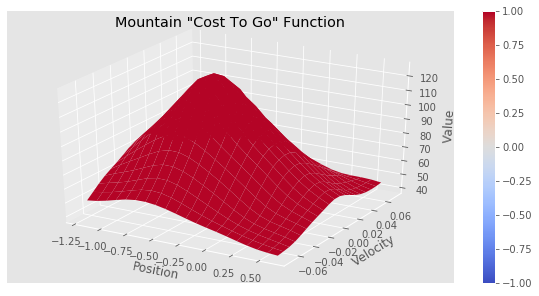

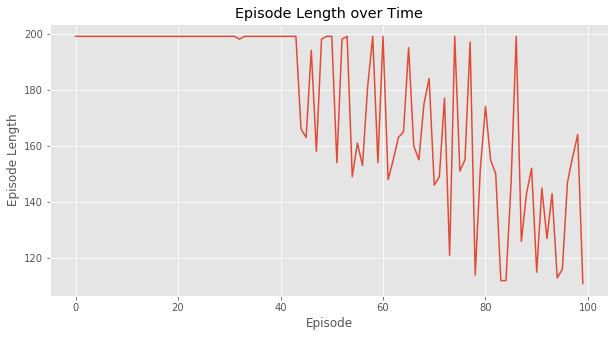

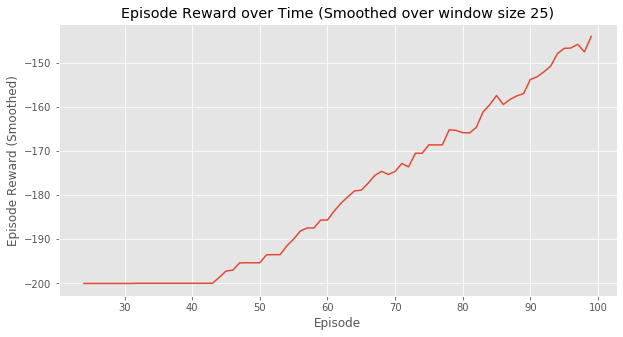

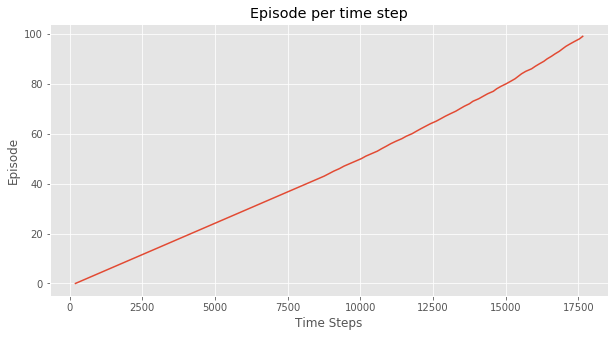

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [9]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)